# Notebook 6: Sumário de Medições e Cálculo de Incertezas

## Curso ABAR - Medições Inteligentes e Gestão Integrada

### Objetivo
1. Construir o sumário das condições operacionais do distrito
2. Calcular incertezas combinadas usando o método RSS

### Conceitos-chave

**Incerteza de Medição:** Parâmetro que caracteriza a dispersão dos valores que podem ser razoavelmente atribuídos ao mensurando.

**Método RSS (Root Sum of Squares):** Quando incertezas são independentes, a incerteza combinada é:

$$U_{combinada} = \sqrt{u_1^2 + u_2^2 + ... + u_n^2}$$

**Incerteza Expandida:** Para 95% de confiança (k=2):

$$U_{expandida} = k \times U_{combinada}$$

**Limites regulamentares:**
- Medição fiscal: ±1%
- Transferência de custódia: ±1%
- Apropriação: ±3%

In [1]:
import sys
from pathlib import Path

# Configurar caminhos do projeto
PROJECT_ROOT = Path('.').resolve().parent if Path('.').resolve().name == 'notebooks' else Path('.').resolve()
sys.path.insert(0, str(PROJECT_ROOT / 'src'))
from config import DATA_DIR, GRAFICOS_DIR, EXCEL_DEFAULT

EXCEL_PATH = DATA_DIR / EXCEL_DEFAULT
GRAFICOS_DIR.mkdir(parents=True, exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

## 1. Construção do Sumário de Condições Operacionais

Vamos calcular as estatísticas de volume, pressão e temperatura para cada ponto de medição.

In [2]:
# Mapeamento de clientes
CLIENTES = {
    'Cliente #1': 'Empresa A',
    'Cliente #2': 'Empresa B',
    'Cliente #3': 'Empresa C',
    'Cliente #4': 'Empresa D',
    'Cliente #5': 'Empresa E',
    'Cliente #6': 'Empresa F',
    'Cliente #7': 'Empresa G'
}

# Volumes de referência (Planilha1) para clientes sem dados horários
VOLUMES_REFERENCIA = {
    'Empresa D': 88184  # Nm³ total no período
}

# Carregar dados dos clientes
dados_clientes = {}
for aba, nome in CLIENTES.items():
    df = pd.read_excel(EXCEL_PATH, sheet_name=aba, header=2, usecols='B:E')
    df.columns = ['Data', 'Volume_Nm3h', 'Pressao_bara', 'Temperatura_C']
    df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
    for col in ['Volume_Nm3h', 'Pressao_bara', 'Temperatura_C']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=['Data']).reset_index(drop=True)
    sem_dados = len(df) == 0 or df['Volume_Nm3h'].dropna().empty
    dados_clientes[aba] = {'nome': nome, 'dados': df, 'sem_dados': sem_dados}

# Carregar dados de entrada
df_vol_ent = pd.read_excel(EXCEL_PATH, sheet_name='Vol Entrada Gas', header=1, usecols='B:D')
df_vol_ent.columns = ['Data', 'Vol_Conc', 'Vol_Transp']
df_vol_ent['Data'] = pd.to_datetime(df_vol_ent['Data'], errors='coerce')
for col in ['Vol_Conc', 'Vol_Transp']:
    df_vol_ent[col] = pd.to_numeric(df_vol_ent[col], errors='coerce')
df_vol_ent = df_vol_ent.dropna(subset=['Data']).reset_index(drop=True)

print('Dados carregados com sucesso!')
for aba, info in dados_clientes.items():
    if info['sem_dados']:
        print(f'  AVISO: {info["nome"]} sem dados horários '
              f'(usando vol. referência: {VOLUMES_REFERENCIA.get(info["nome"], 0):,.0f} Nm³)')

Dados carregados com sucesso!


In [3]:
# Construir tabela de sumário
sumario = []

# Entrada (converter Nm3/d para Nm3/h dividindo por 24)
vol_ent_h = df_vol_ent['Vol_Conc'] / 24
sumario.append({
    'Ponto': 'Entrada (Concessionária)',
    'Tipo': 'Entrada',
    'Vol Mín (Nm³/h)': vol_ent_h.min(),
    'Vol Méd (Nm³/h)': vol_ent_h.mean(),
    'Vol Máx (Nm³/h)': vol_ent_h.max(),
    'Vol Total (Nm³)': df_vol_ent['Vol_Conc'].sum(),
    'Press Méd (bara)': np.nan,
    'Press Máx (bara)': np.nan,
    'Temp Méd (°C)': np.nan,
    'Temp Máx (°C)': np.nan
})

# Saídas (clientes)
for aba, info in dados_clientes.items():
    df = info['dados']
    if info['sem_dados']:
        vol_ref = VOLUMES_REFERENCIA.get(info['nome'], 0)
        sumario.append({
            'Ponto': info['nome'] + ' *',
            'Tipo': 'Saída',
            'Vol Mín (Nm³/h)': np.nan,
            'Vol Méd (Nm³/h)': np.nan,
            'Vol Máx (Nm³/h)': np.nan,
            'Vol Total (Nm³)': vol_ref,
            'Press Méd (bara)': np.nan,
            'Press Máx (bara)': np.nan,
            'Temp Méd (°C)': np.nan,
            'Temp Máx (°C)': np.nan
        })
    else:
        sumario.append({
            'Ponto': info['nome'],
            'Tipo': 'Saída',
            'Vol Mín (Nm³/h)': df['Volume_Nm3h'].min(),
            'Vol Méd (Nm³/h)': df['Volume_Nm3h'].mean(),
            'Vol Máx (Nm³/h)': df['Volume_Nm3h'].max(),
            'Vol Total (Nm³)': df['Volume_Nm3h'].sum(),
            'Press Méd (bara)': df['Pressao_bara'].mean(),
            'Press Máx (bara)': df['Pressao_bara'].max(),
            'Temp Méd (°C)': df['Temperatura_C'].mean(),
            'Temp Máx (°C)': df['Temperatura_C'].max()
        })

df_sumario = pd.DataFrame(sumario)

# Adicionar total de saídas
saidas = df_sumario[df_sumario['Tipo'] == 'Saída']
total_saida = saidas['Vol Total (Nm³)'].sum()

print('=== SUMÁRIO DE CONDIÇÕES OPERACIONAIS DO DISTRITO ===')
print(f'\nPeríodo: Abril a Setembro de 2025')
print(f'* = Volume de referência (Planilha1), sem dados horários\n')
df_sumario[['Ponto', 'Vol Mín (Nm³/h)', 'Vol Méd (Nm³/h)', 'Vol Máx (Nm³/h)', 
            'Vol Total (Nm³)', 'Press Méd (bara)', 'Temp Méd (°C)']]

=== SUMÁRIO DE CONDIÇÕES OPERACIONAIS DO DISTRITO ===

Período: Abril a Setembro de 2025
* = Volume de referência (Planilha1), sem dados horários



,Ponto,Vol Mín (Nm³/h),Vol Méd (Nm³/h),Vol Máx (Nm³/h),Vol Total (Nm³),Press Méd (bara),Temp Méd (°C)
0,Entrada (Concessionária),21081.872396,41648.417592,51702.703125,1.829199e+08,NaN,NaN
1,Empresa A,1359.000000,23965.136510,31245.000000,1.041046e+08,15.472541,23.489390
2,Empresa B,178.000000,10051.674724,17113.000000,4.366448e+07,15.957836,23.413527
3,Empresa C,0.000000,1566.692695,4959.000000,6.841747e+06,5.150195,17.836618
4,Empresa D,0.000000,47.385277,187.000000,8.818400e+04,18.571698,23.639398
5,Empresa E,300.000000,2344.531538,4244.000000,1.018464e+07,4.925134,16.698080
6,Empresa F,0.000000,1371.526703,3509.000000,5.957912e+06,7.545279,20.490311
7,Empresa G,418.000000,2320.884899,7085.000000,1.008192e+07,7.335753,18.522756


In [4]:
# Calcular perda do distrito
vol_entrada = df_sumario[df_sumario['Tipo'] == 'Entrada']['Vol Total (Nm³)'].values[0]
vol_saida = saidas['Vol Total (Nm³)'].sum()
diferenca = vol_entrada - vol_saida
diferenca_pct = (diferenca / vol_entrada) * 100

print(f'=== BALANÇO VOLUMÉTRICO ===')
print(f'Volume de Entrada: {vol_entrada:>20,.0f} Nm³')
print(f'Soma das Saídas:   {vol_saida:>20,.0f} Nm³')
print(f'Diferença:         {diferenca:>20,.0f} Nm³')
print(f'Diferença (%):     {diferenca_pct:>20.2f}%')
print(f'\n** Valor esperado da planilha: ~0,64% **')

=== BALANÇO VOLUMÉTRICO ===
Volume de Entrada:          182,919,850 Nm³
Soma das Saídas:            180,923,440 Nm³
Diferença:                    1,996,410 Nm³
Diferença (%):                     1.09%

** Valor esperado da planilha: ~0,64% **


## 2. Cálculo de Incertezas

### Incertezas individuais por ponto de medição
Os valores de incerteza vêm da aba "Incertezas" da planilha, que refletem:
- Incerteza do medidor de vazão
- Incerteza dos transmissores de pressão e temperatura
- Incerteza do fator de compressibilidade
- Incerteza da composição (cromatografia)

In [5]:
# Incertezas por ponto de medição (valores da aba "Incertezas", em fração decimal)
# Entrada: Tramo 101 (célula G7) = 0.0106, Tramo 501 (célula G11) = 0.0109
# Fórmula da planilha: =SQRT(G7^2+G11^2)
incertezas = {
    'Entrada - Tramo 101 (Comgás 1)': 0.0106,
    'Entrada - Tramo 501 (Comgás 2)': 0.0109,
    'Empresa A': 0.0133,
    'Empresa B': 0.0161,
    'Empresa C': 0.0134,
    'Empresa D': 0.0358,
    'Empresa E': 0.0305,
    'Empresa F': 0.0148,
    'Empresa G': 0.028
}

print('=== Incertezas Individuais por Ponto de Medição ===')
for ponto, inc in incertezas.items():
    print(f'{ponto:<40} {inc*100:.2f}%')

=== Incertezas Individuais por Ponto de Medição ===
Entrada - Tramo 101 (Comgás 1)           1.06%
Entrada - Tramo 501 (Comgás 2)           1.09%
Empresa A                              1.33%
Empresa B                      1.61%
Empresa C                        1.34%
Empresa D                               3.58%
Empresa E                     3.05%
Empresa F                              1.48%
Empresa G                             2.80%


### Cálculo da Incerteza Combinada (RSS)

Para pontos de medição **independentes**, a incerteza combinada é calculada pela raiz da soma dos quadrados:

$$U_{combinada} = \sqrt{u_1^2 + u_2^2 + ... + u_n^2}$$

In [6]:
# Incerteza combinada da ENTRADA
inc_entrada = [incertezas['Entrada - Tramo 101 (Comgás 1)'], incertezas['Entrada - Tramo 501 (Comgás 2)']]
u_entrada = np.sqrt(np.sum(np.array(inc_entrada)**2))

print('=== INCERTEZA COMBINADA DA ENTRADA (RSS) ===')
print(f'Tramo 101: {inc_entrada[0]*100:.2f}%')
print(f'Tramo 501: {inc_entrada[1]*100:.2f}%')
print(f'Fórmula: sqrt({inc_entrada[0]:.4f}² + {inc_entrada[1]:.4f}²)')
print(f'U_entrada = sqrt({inc_entrada[0]**2:.8f} + {inc_entrada[1]**2:.8f})')
print(f'U_entrada = sqrt({sum(x**2 for x in inc_entrada):.8f})')
print(f'U_entrada = {u_entrada:.4f} = {u_entrada*100:.2f}%')
print(f'\n** Valor esperado: ~1,52% **')

=== INCERTEZA COMBINADA DA ENTRADA (RSS) ===
Tramo 101: 1.06%
Tramo 501: 1.09%
Fórmula: sqrt(0.0106² + 0.0109²)
U_entrada = sqrt(0.00011236 + 0.00011881)
U_entrada = sqrt(0.00023117)
U_entrada = 0.0152 = 1.52%

** Valor esperado: ~1,52% **


In [7]:
# Incerteza combinada das SAÍDAS
inc_saidas = [
    incertezas['Empresa A'],
    incertezas['Empresa B'],
    incertezas['Empresa C'],
    incertezas['Empresa D'],
    incertezas['Empresa E'],
    incertezas['Empresa F'],
    incertezas['Empresa G']
]

u_saida = np.sqrt(np.sum(np.array(inc_saidas)**2))

print('=== INCERTEZA COMBINADA DAS SAÍDAS (RSS) ===')
print('Fórmula: sqrt(', end='')
for i, inc in enumerate(inc_saidas):
    if i > 0:
        print(' + ', end='')
    print(f'{inc:.4f}²', end='')
print(')')
print(f'\nU_saída = sqrt({sum(x**2 for x in inc_saidas):.8f})')
print(f'U_saída = {u_saida:.4f} = {u_saida*100:.2f}%')
print(f'\n** Valor esperado: ~6,19% (vazao normal) **')

=== INCERTEZA COMBINADA DAS SAÍDAS (RSS) ===
Fórmula: sqrt(0.0133² + 0.0161² + 0.0134² + 0.0358² + 0.0305² + 0.0148² + 0.0280²)

U_saída = sqrt(0.00383059)
U_saída = 0.0619 = 6.19%

** Valor esperado: ~6,19% (vazao normal) **


## 3. Gráficos

### 3.1 Incerteza por Ponto de Medição

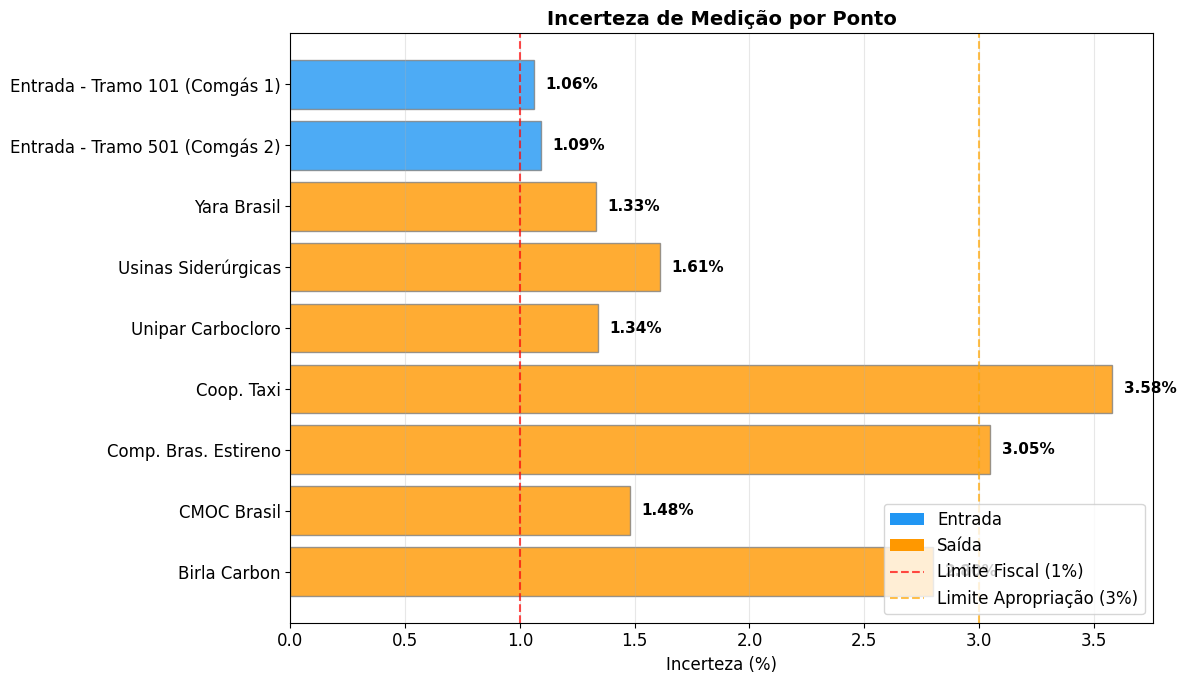

In [8]:
fig, ax = plt.subplots(figsize=(12, 7))

pontos = list(incertezas.keys())
valores = [v * 100 for v in incertezas.values()]  # Em percentual

cores = ['#2196F3' if 'Entrada' in p else '#FF9800' for p in pontos]

bars = ax.barh(pontos[::-1], valores[::-1], color=cores[::-1], alpha=0.8, edgecolor='gray')

# Rótulos
for bar, val in zip(bars, valores[::-1]):
    ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
            f'{val:.2f}%', va='center', fontsize=11, fontweight='bold')

# Linha de referência (1% limite fiscal)
ax.axvline(x=1.0, color='red', linestyle='--', alpha=0.7, label='Limite Fiscal (1%)')
ax.axvline(x=3.0, color='orange', linestyle='--', alpha=0.7, label='Limite Apropriação (3%)')

ax.set_title('Incerteza de Medição por Ponto', fontsize=14, fontweight='bold')
ax.set_xlabel('Incerteza (%)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

# Legenda de cores
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2196F3', label='Entrada'),
                   Patch(facecolor='#FF9800', label='Saída')]
ax.legend(handles=legend_elements + ax.get_legend_handles_labels()[0][:2], loc='lower right')

plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'incertezas_barras.png'), dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Incertezas Combinadas

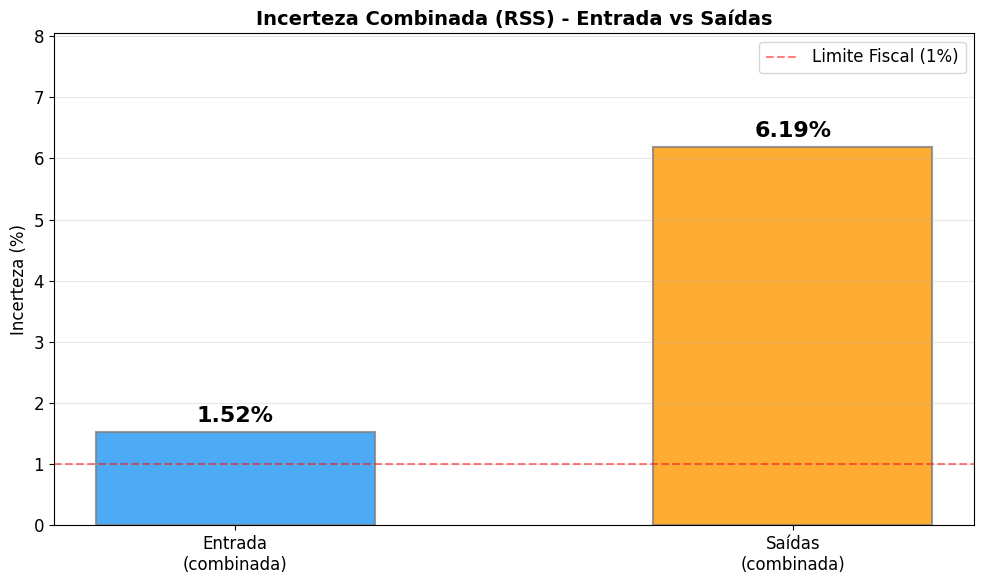

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

categorias = ['Entrada\n(combinada)', 'Saídas\n(combinada)']
u_valores = [u_entrada * 100, u_saida * 100]
cores = ['#2196F3', '#FF9800']

bars = ax.bar(categorias, u_valores, color=cores, alpha=0.8, 
              width=0.5, edgecolor='gray', linewidth=1.5)

# Rótulos
for bar, val in zip(bars, u_valores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.2f}%', ha='center', va='bottom', fontsize=16, fontweight='bold')

# Referências
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Limite Fiscal (1%)')

ax.set_title('Incerteza Combinada (RSS) - Entrada vs Saídas', fontsize=14, fontweight='bold')
ax.set_ylabel('Incerteza (%)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(u_valores) * 1.3)

plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'incertezas_rss.png'), dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Contribuição de Cada Ponto na Incerteza Total das Saídas

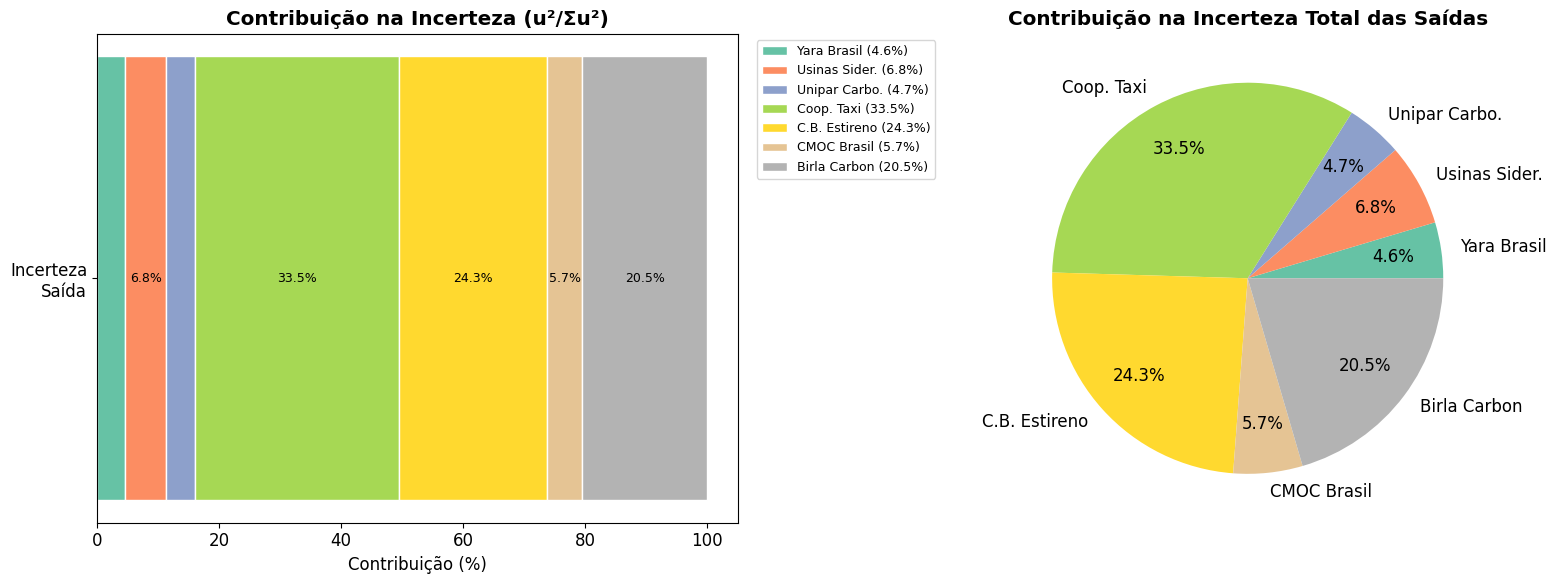

In [10]:
# A contribuição de cada componente na incerteza RSS é proporcional a u_i²
nomes_saida = ['Empresa A', 'Empresa B', 'Empresa C', 
               'Empresa D', 'Empresa E', 'Empresa F', 'Empresa G']

contribuicoes = [(inc**2) / sum(x**2 for x in inc_saidas) * 100 for inc in inc_saidas]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Barras empilhadas horizontais
cores_contrib = plt.cm.Set2(np.linspace(0, 1, len(nomes_saida)))
left = 0
for i, (nome, contrib) in enumerate(zip(nomes_saida, contribuicoes)):
    ax1.barh('Incerteza\nSaída', contrib, left=left, color=cores_contrib[i], 
             label=f'{nome} ({contrib:.1f}%)', edgecolor='white')
    if contrib > 5:
        ax1.text(left + contrib/2, 0, f'{contrib:.1f}%', ha='center', va='center', fontsize=9)
    left += contrib

ax1.set_title('Contribuição na Incerteza (u²/Σu²)', fontweight='bold')
ax1.set_xlabel('Contribuição (%)')
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

# Pizza
ax2.pie(contribuicoes, labels=nomes_saida, autopct='%1.1f%%',
        colors=cores_contrib, pctdistance=0.75)
ax2.set_title('Contribuição na Incerteza Total das Saídas', fontweight='bold')

plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'incertezas_contribuicao.png'), dpi=150, bbox_inches='tight')
plt.show()

## 4. Conclusões

### Observações:
- Incerteza combinada da **entrada: ~1,52%** (acima do limite fiscal de 1%, mas aceitável para distribuição)
- Incerteza combinada das **saídas: ~6,19%** (maior devido à soma de múltiplos pontos)
- **Empresa D** tem a maior incerteza individual (3,58%) mas contribui pouco no total pelo baixo volume
- O método RSS é o padrão metrológico (GUM 2008) para combinar incertezas independentes
- Estas incertezas definem as **bandas de variação** usadas no balanço de massa (Notebook 7)